# EfficientNet with Squeeze Excitation

In this model, our team builds of the efficientNet infrastructure, where we have introduced a Squeeze Excitation block in the classifier head.

## Imports
Used to handle the imports

In [ ]:
from typing import List, Optional, Callable
import os
import sys
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-20 12:30:05,228	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-20 12:30:05,365	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


ImportError: attempted relative import with no known parent package

## Loading Dataset and File Location Variables
All code that handles renaming of file location save files

Ability to set the following variables
- **model_name**: Name the current model that is being created
- **batch_size**: The size of each batch of data
- **root**: Declare the root folder of the project (should usually be ..)
- **model_directory**: Declare the folder that models will be saved in (should be standardised to models)
- **dataset_folder**: Location for the dataset folder (should be "../../input/final_split_15Apr2025")



Which creates the following global variables
- PROJECT_ROOT:
- LOG_DIR:
- MODEL_SAVE_DIR:
- DEVICE:
- SPLIT_DATASET:
- BATCH_SIZE: 
- TRAIN_LOADER, VAL_LOADER, TEST_LOADER:
- FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER: 

In [23]:
# Rename variables to control where files are saved

model_name = "ENSE" # Name of the model that the file is training in abbreviation
batch_size = 64 # State the number of datapoints in each batch size
root = ".." # Os path to the root of the project
model_directory = "models" # Name of the folder where the models will be stored
dataset_folder = "../input/final_split_15Apr2025" # Abs Location of the folder with the data split into train eval test
root_result_folder = "results"

In [25]:
# Determine the project root - required to import DataHandler from utils folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), root))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Configuring log file
LOG_DIR = os.path.join(PROJECT_ROOT, "logs")
os.makedirs(LOG_DIR, exist_ok=True)
log_filename = os.path.join(LOG_DIR, F"{model_name}_training_log.txt")
logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

# Creating the models save location
MODEL_SAVE_DIR = os.path.join(PROJECT_ROOT, model_directory, model_name)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, F"{model_directory}/hyptune/{model_name}")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

RESULTS_DIR = os.path.join(PROJECT_ROOT, F"{root_result_folder}/{model_name}")
print(RESULTS_DIR)
os.makedirs(RESULTS_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, F"{model_name}_best_model.pt")

# Gets the device to be used
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

DEVICE = get_device()

c:\Users\yongl\OneDrive\Documents\GitHub\DogEmotionADL\results/ENSE
Using device: CUDA (GPU)


Loading the datasets for both hyperparameter tuning as well as actual trianing

In [26]:
SPLIT_DATASET = os.path.abspath(dataset_folder)
BATCH_SIZE = batch_size

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    weights.transforms()
])

# Creating dataloader to load 50% of the dataset with the same proportions used for hyper parameter tuning
TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
    subset_fraction=0.5,
    random_seed=42
)

# Creating dataloader to load the full dataset for training the actual models and testing
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69
Using pre-split datasets: train 8025, val 579, test 572


## Model Specification
This part of the file will change largely based on each of the models that are being created


In [5]:
class SqueezeExcitationBlock(nn.Module):
    """
    Squeeze-and-Excitation (SE) block for channel-wise feature recalibration.

    This block implements the SE mechanism which adaptively recalibrates 
    channel-wise feature responses by explicitly modeling interdependencies 
    between channels.

    Args:
        channels (int): Number of input and output channels.
        reduction_ratio (int): Reduction ratio for the intermediate hidden layer. 
            Controls the bottleneck in the SE block (default: 16).

    Forward Input:
        x (Tensor): Input feature map of shape (batch_size, channels, height, width).

    Forward Output:
        Tensor: Output feature map of the same shape, with recalibrated channel responses.
    """

    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class BaseEfficientNetB5(nn.Module):
    """
    EfficientNetB5-based classifier with optional Squeeze-and-Excitation (SE) block, 
    customizable classifier head, and partial layer unfreezing for fine-tuning.

    Designed for flexibility during hyperparameter tuning (e.g., with Ray Tune).

    Args:
        num_classes (int): Number of output classes. Default is 4.
        dropout (float): Dropout probability used in the classifier head. Default is 0.2.
        hidden_sizes (Optional[List[int]]): List of hidden layer sizes for the classifier head. 
            If None, no additional hidden layers are added beyond the SE block (if used).
        activation (str): Activation function to use in the classifier head. 
            Supported values: 'relu', 'tanh', 'sigmoid'. Default is 'relu'.
        use_se (bool): Whether to include a Squeeze-and-Excitation (SE) block before the classifier. Default is True.
        unfreeze_blocks (Optional[List[int]]): List of block indices in EfficientNetB5's features to unfreeze 
            for fine-tuning. If None, the entire backbone remains frozen.

    Notes:
        - The SE block is applied to the flattened output of the backbone if `use_se` is True.
        - The classifier head is built dynamically based on `hidden_sizes` and activation.
        - The EfficientNetB5 backbone is loaded with pretrained weights by default.
    """
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu',
                 use_se: bool = True,
                 unfreeze_blocks: Optional[List[int]] = None) -> None:
        super(BaseEfficientNetB5, self).__init__()
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights)
        in_features = self.backbone.classifier[1].in_features

        # Setting the values layers in the efficientnet backbone that will be frozen
        for param in self.backbone.features.parameters():
            param.requires_grad = False

        if unfreeze_blocks:
            for idx in unfreeze_blocks:
                for param in self.backbone.features[idx].parameters():
                    param.requires_grad = True

        # Build the classifier head with the SE and additional layers according to the number of layers in the hidden state
        layers = []
        if use_se:
            layers.extend([
                nn.Unflatten(1, (in_features, 1, 1)),
                SqueezeExcitationBlock(in_features),
                nn.Flatten()
            ])
        
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
        
        layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(input_dim, num_classes))

        self.backbone.classifier[1] = nn.Sequential(*layers)

    def _get_activation(self, activation: str) -> Callable:
        """
        Returns the specified activation function from PyTorch's nn module.

        Args:
            activation (str): Name of the activation function. Supported values are
                'relu', 'tanh', and 'sigmoid' (case-insensitive).

        Returns:
            Callable: The corresponding activation function module (e.g., nn.ReLU()).

        Raises:
            ValueError: If an unsupported activation function name is provided.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

In [6]:
print(f"Using device: {DEVICE}")
model = BaseEfficientNetB5(num_classes=4, dropout=0.3, hidden_sizes=[256, 128], activation='relu', unfreeze_blocks=[7]).to(DEVICE)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda
Model instantiated: BaseEfficientNetB5
BaseEfficientNetB5(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))

## Hyper Parameter Tuning

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune

def train_model(config, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = BaseEfficientNetB5(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu"),
        unfreeze_blocks = config.get("unfreeze_blocks", [7])
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        
        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    
    avg_val_loss = total_loss / len(VAL_LOADER.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss})

In [ ]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,           # max training iterations per trial
    grace_period=2,     # min iterations before stopping
    reduction_factor=2,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try, this is just example of format

# for efficientnetb5 gpu
config = {
    "lr": tune.loguniform(1e-5, 5e-5),    
    "weight_decay": tune.loguniform(1e-5, 2e-5),
    "dropout": tune.uniform(0.39, 0.41),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu"]), #Removed gelu
    "unfreeze_blocks": tune.choice([[6, 7]]),
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": lambda: nn.CrossEntropyLoss()
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 12, "gpu": 1}), #NOTE:specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name=model_name,
        storage_path=F"C:/ray_results/{model_name}", #NOTE: not required for macos
        log_to_file=True,
        verbose=1),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min", filter_nan_and_inf=False).config)

# Extracting the best config from the training from above
best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

(train_model pid=24276) Checkpoint Folder exists


Epoch 1/10:  98%|█████████▊| 62/63 [01:06<00:01,  1.04s/it]


(train_model pid=24276) Epoch 1/10, Training Loss: 1.3918


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24276) Epoch 2/10, Training Loss: 1.3922


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24276) Epoch 3/10, Training Loss: 1.3902


Epoch 4/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=24276) Epoch 4/10, Training Loss: 1.3916


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24276) Epoch 5/10, Training Loss: 1.3910


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24276) Epoch 6/10, Training Loss: 1.3906


Epoch 7/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=24276) Epoch 7/10, Training Loss: 1.3913


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24276) Epoch 8/10, Training Loss: 1.3902


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24276) Epoch 9/10, Training Loss: 1.3916


Epoch 10/10: 100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


(train_model pid=24276) Epoch 10/10, Training Loss: 1.3900


2025-04-20 10:45:02,347	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=24276) Validation Loss: 1.3883
(train_model pid=21864) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21864) Epoch 1/10, Training Loss: 1.3888


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21864) Epoch 2/10, Training Loss: 1.3889


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21864) Epoch 3/10, Training Loss: 1.3888


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21864) Epoch 4/10, Training Loss: 1.3868


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21864) Epoch 5/10, Training Loss: 1.3846


Epoch 6/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=21864) Epoch 6/10, Training Loss: 1.3841


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21864) Epoch 7/10, Training Loss: 1.3851


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21864) Epoch 8/10, Training Loss: 1.3841


Epoch 9/10: 100%|██████████| 63/63 [01:03<00:00,  1.02s/it]


(train_model pid=21864) Epoch 9/10, Training Loss: 1.3820


Epoch 10/10: 100%|██████████| 63/63 [01:03<00:00,  1.01s/it]


(train_model pid=21864) Epoch 10/10, Training Loss: 1.3807


2025-04-20 10:55:55,249	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=21864) Validation Loss: 1.3791
(train_model pid=20840) Checkpoint Folder exists


2025-04-20 10:55:58,973	ERROR tune_controller.py:1331 -- Trial task failed for trial t_c8c52f13
Traceback (most recent call last):
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\ray\_private\worker.py", line 929, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::Im

(train_model pid=7692) Epoch 1/10, Training Loss: 1.3906
(train_model pid=7692) Checkpoint Folder exists


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7692) Epoch 2/10, Training Loss: 1.3885


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7692) Epoch 3/10, Training Loss: 1.3891


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7692) Epoch 4/10, Training Loss: 1.3880


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7692) Epoch 5/10, Training Loss: 1.3891


Epoch 6/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=7692) Epoch 6/10, Training Loss: 1.3883


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7692) Epoch 7/10, Training Loss: 1.3870


Epoch 8/10: 100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


(train_model pid=7692) Epoch 8/10, Training Loss: 1.3873


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=7692) Epoch 9/10, Training Loss: 1.3863


Epoch 10/10: 100%|██████████| 63/63 [01:04<00:00,  1.02s/it]


(train_model pid=7692) Epoch 10/10, Training Loss: 1.3843


2025-04-20 11:06:53,831	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=7692) Validation Loss: 1.3833
(train_model pid=22184) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=22184) Epoch 1/10, Training Loss: 1.3873


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=22184) Epoch 2/10, Training Loss: 1.3874


Epoch 3/10:  49%|████▉     | 31/63 [00:32<00:33,  1.05s/it]
2025-04-20 11:09:40,336	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-04-20 11:09:40,345	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/ENSE/ENSE' in 0.0090s.
Epoch 3/10:  63%|██████▎   | 40/63 [00:42<00:24,  1.06s/it]
2025-04-20 11:09:50,415	ERROR tune.py:1037 -- Trials did not complete: [t_c8c52f13]
2025-04-20 11:09:50,415	INFO tune.py:1041 -- Total run time: 2148.38 seconds (2138.23 seconds for the tuning loop).
2025-04-20 11:09:50,415	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="C:/ray_results/ENSE/ENSE", trainable=...)
2025-04-20 11:09:50,436	WARNING experiment_analysis.py:180 -- Failed to fetch metrics fo

Best config: {'lr': 3.818145165896868e-05, 'weight_decay': 1.1585650991012693e-05, 'dropout': 0.393636499344142, 'hidden_sizes': None, 'activation': 'sigmoid', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x00000205801FDBD0>, 'criterion': <function <lambda> at 0x00000205801FD870>}
Full best config: {'lr': 3.818145165896868e-05, 'weight_decay': 1.1585650991012693e-05, 'dropout': 0.393636499344142, 'hidden_sizes': None, 'activation': 'sigmoid', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x00000205801FDBD0>, 'criterion': <function <lambda> at 0x00000205801FD870>}


## Final Model Training

In [7]:
#### Good configs, saved after various experimentations
# This cell can be skipped if hyper parameter tuning was run
best_config = {
    'lr': 2.5883109107619077e-05,
    'weight_decay': 1.5994372155012393e-05,
    'dropout': 0.4016587828927856,
    'hidden_sizes': None,
    'activation': 'leakyrelu',
    'unfreeze_blocks': [6, 7],
    'num_epochs': 10,
    'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
    'criterion': lambda: nn.CrossEntropyLoss()
}

In [8]:
final_model = BaseEfficientNetB5(
    num_classes=4,
    dropout=best_config["dropout"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"],
    unfreeze_blocks=best_config["unfreeze_blocks"]
)

optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

final_model = final_model.to(DEVICE)
logging.info("Model instantiated on device: %s", DEVICE)

In [30]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(FULL_TRAIN_LOADER.dataset)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(FULL_VAL_LOADER.dataset)
    val_losses.append(epoch_val_loss)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        torch.save(final_model.state_dict(), BEST_MODEL_PATH)
        logging.info("Model saved to: %s",  {BEST_MODEL_PATH})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50: 100%|██████████| 126/126 [02:08<00:00,  1.02s/it]


Epoch 1/50 - Train Loss: 0.1654, Val Loss: 0.3928


Epoch 2/50: 100%|██████████| 126/126 [02:08<00:00,  1.02s/it]


Epoch 2/50 - Train Loss: 0.1270, Val Loss: 0.3913


Epoch 3/50: 100%|██████████| 126/126 [02:08<00:00,  1.02s/it]


Epoch 3/50 - Train Loss: 0.1013, Val Loss: 0.3605


Epoch 4/50: 100%|██████████| 126/126 [02:13<00:00,  1.06s/it]


KeyboardInterrupt: 

## Testing

Test Loss: 0.3373, Test Accuracy: 86.54%


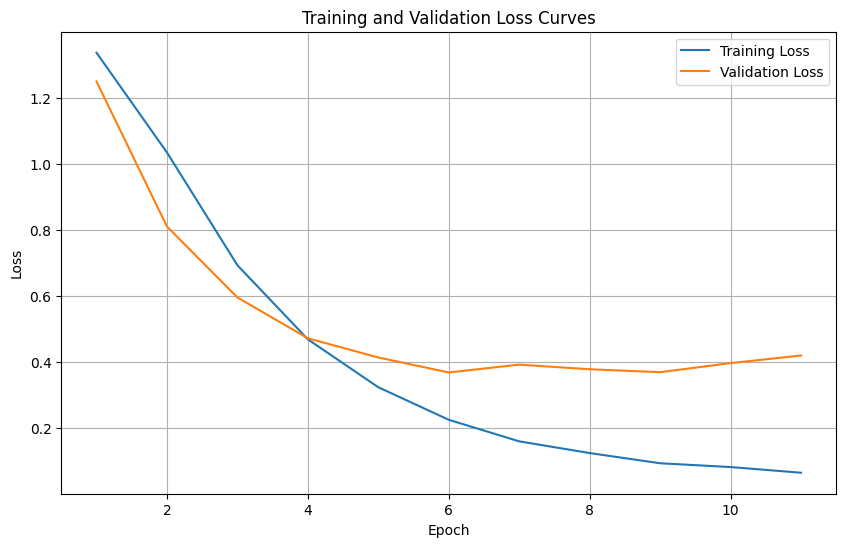


Classification Report:
               precision    recall  f1-score   support

       angry       0.94      0.86      0.90       140
       happy       0.92      0.93      0.92       148
     relaxed       0.78      0.86      0.82       146
         sad       0.84      0.81      0.82       138

    accuracy                           0.87       572
   macro avg       0.87      0.86      0.87       572
weighted avg       0.87      0.87      0.87       572



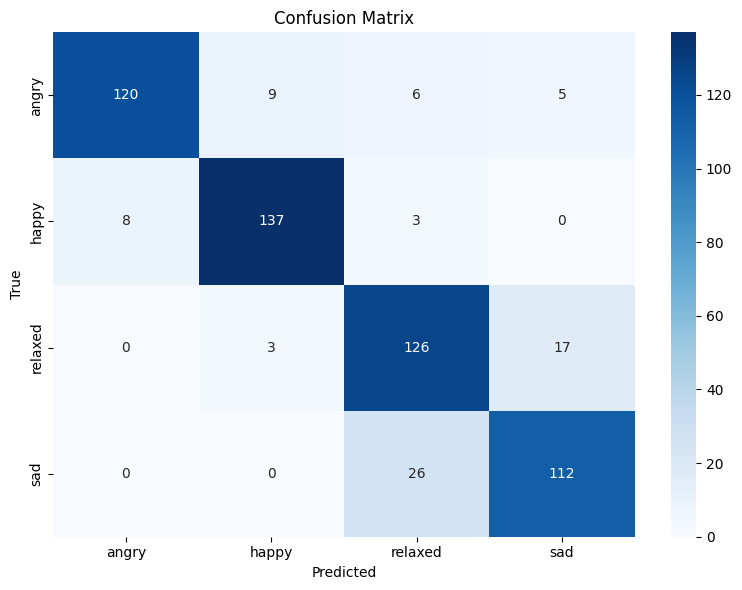

In [29]:
# load best model from training 
final_model.load_state_dict(torch.load(BEST_MODEL_PATH)) 
final_model.to(DEVICE) 
final_model.eval() 
 
# initialise metrics 
correct = 0 
total = 0 
test_loss = 0.0 
all_preds = [] 
all_labels = [] 
 
with torch.no_grad(): 
    for images, labels in FULL_TEST_LOADER: 
        images, labels = images.to(DEVICE), labels.to(DEVICE) 
        outputs = final_model(images) 
        # for test loss 
        loss = criterion(outputs, labels) 
        test_loss += loss.item() * images.size(0) 
        # for accuracy 
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum().item() 
 
        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu 
        all_labels.extend(labels.cpu().numpy()) 
 
test_loss = test_loss / len(FULL_TEST_LOADER.dataset) 
test_accuracy = correct / total 
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%") 
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100) 
 
# plotting training and validation loss curves 
if 'train_losses' in globals() and 'val_losses' in globals(): 
    plt.figure(figsize=(10, 6)) 
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss") 
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss") 
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.title("Training and Validation Loss Curves") 
    plt.legend() 
    plt.grid(True) 
    loss_curve_path = os.path.join(PROJECT_ROOT, "results", model_name, "loss_curves.png") #NOTE: specify by model name 
    plt.savefig(loss_curve_path) 
    plt.show() 
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path) 
else: 
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.") 
 
# generate and log classification report 
class_names = FULL_TEST_LOADER.dataset.classes 
report = classification_report(all_labels, all_preds, target_names=class_names) 
print("\nClassification Report:\n", report) 
logging.info("Classification Report:\n%s", report) 
 
# generate confusion matrix 
cm = confusion_matrix(all_labels, all_preds) 
 
# save confusion matrix as image 
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax) 
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.title("Confusion Matrix") 
plt.tight_layout() 
 

conf_matrix_path = os.path.join(PROJECT_ROOT, "results", model_name, "confusion_matrix.png") #NOTE: specify by model name 
fig.savefig(conf_matrix_path) 
plt.show(fig) 
 
logging.info("Confusion matrix saved to: %s", conf_matrix_path)
